In [11]:
import torch.nn.functional as F

def gen_laplacian_pyramid(image_tensor, n_pyramid_levels):
  '''
  Generate the Laplacian pyramid representation of the image.

  Input: 
  
  image_tensor: An image tensor.

  Output:

  laplacian_pyramid: a list of residual image tensors of successively lower 
  resolution and the low resolution image tensor.

  '''
  # laplacian_pyramid = []
  laplacian_pyramid = list()
  # successively manipulate images
  for i in range(n_pyramid_levels):
    # downsample the image (blur + decimate)
    blurred_image = F.avg_pool2d(image_tensor, kernel_size=2, stride=2) # gaussian pyramid
    # upsample the blurred image (smooth + upsample) (bilinear vs. bicubic?) (this is the prediction)
    upsampled_image = F.interpolate(blurred_image, scale_factor=2, mode='bilinear', align_corners=False)
    # calculate the residual image: I_res = I_upsampled - I_downsampled
    res = image_tensor - upsampled_image 
    # append the residual/Laplacian image to the list
    laplacian_pyramid.append(res)
    # update the image
    image_tensor = blurred_image
  # append the lowest level/resolution image to the list
  laplacian_pyramid.append(image_tensor)
  return(laplacian_pyramid)

In [4]:
import torch
# import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
# import tqdm

## size of a mini-batch
batch_size = 4

# The images are PIL with range [0,1]. We want tensors with range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = CIFAR10('.', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0.0%

100.0%


Extracting .\cifar-10-python.tar.gz to .


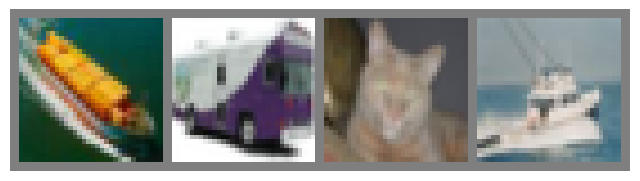

ship  truck cat   ship 


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# functions to show an image
# def image_grid(x):
#   size = config.data.image_size
#   channels = config.data.num_channels
#   img = x.reshape(-1, size, size, channels)
#   w = int(np.sqrt(img.shape[0]))
#   img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
#   return img

# def show_samples(x):
#   img = image_grid(x)
#   plt.figure(figsize=(8,8))
#   plt.axis('off')
#   plt.imshow(img)
#   plt.show()

# show_samples(x)
#-------------------------------------------------------------------------------
def imshow(img):
    # imSize = (32,32)
    # nChannels = 3
    # img = x.reshape(-1, size, size, channels)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(npimg)
    plt.show()


# get some random training images
dataiter = iter(data_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [15]:
# calculate the number of laplacian pyramid levels based on image size
# n_pyramid_levels = math.log2(32)
n_pyramid_levels = 3

# generate the laplacian pyramid for the images
laplacian_pyramid_images = gen_laplacian_pyramid(images, n_pyramid_levels)


In [25]:
print("object type of image pyramid:", type(laplacian_pyramid_images))
print("number of image pyramids in object:", len(laplacian_pyramid_images))
print("size of image pyramid level 0:", laplacian_pyramid_images[0].size())
print("size of image pyramid level 1:", laplacian_pyramid_images[1].size())
print("size of image pyramid level 2:", laplacian_pyramid_images[2].size())
print("size of image pyramid level 3:", laplacian_pyramid_images[3].size())

# print("size of image grid:", laplacian_pyramid_images.size())


object type of image pyramid: <class 'list'>
number of image pyramids in object: 4
size of image pyramid level 0: torch.Size([4, 3, 32, 32])
size of image pyramid level 1: torch.Size([4, 3, 16, 16])
size of image pyramid level 2: torch.Size([4, 3, 8, 8])
size of image pyramid level 3: torch.Size([4, 3, 4, 4])


In [32]:
resized_image = F.interpolate(laplacian_pyramid_images[1], size=output_size, mode='bilinear', align_corners=False)
print("size of image pyramid level 1:", laplacian_pyramid_images[1].size())
print("size of resized image pyramid level 1:", resized_image.size())


size of image pyramid level 1: torch.Size([4, 3, 16, 16])
size of resized image pyramid level 1: torch.Size([4, 3, 32, 32])


In [45]:
import torch.nn.functional as F

def resize_image_by_padding(img, output_size=(32, 32)):
    # Calculate the amount of padding required
    output_size = (32, 32)
    # padding = (0, 0, output_size[1] - img.size(3), output_size[0] - img.size(2))
    padding = ((output_size[1] - img.size(3))/2, 
               (output_size[0] - img.size(2))/2, 
               (output_size[1] - img.size(3))/2, 
               (output_size[0] - img.size(2))/2)
    # padding = np.intc(padding)
    # need padding to be a tuple of ints
    
    # Perform zero padding on the image tensor
    resized_image_tensor = F.pad(img, padding, mode='constant', value=0)
    return(resized_image_tensor)

In [51]:
# resized_image = resize_image_by_padding(laplacian_pyramid_images[1])
padding = (8,8,8,8)
resized_image = F.pad(laplacian_pyramid_images[1], padding, mode='constant', value=0)
print("size of image pyramid level 1:", laplacian_pyramid_images[1].size())
print("size of resized image pyramid level 1:", resized_image.size())

padding = (12,12,12,12)
resized_image = F.pad(laplacian_pyramid_images[2], padding, mode='constant', value=0)
print("size of image pyramid level 2:", laplacian_pyramid_images[2].size())
print("size of resized image pyramid level 2:", resized_image.size())

size of image pyramid level 1: torch.Size([4, 3, 16, 16])
size of resized image pyramid level 1: torch.Size([4, 3, 32, 32])
size of image pyramid level 2: torch.Size([4, 3, 8, 8])
size of resized image pyramid level 2: torch.Size([4, 3, 32, 32])


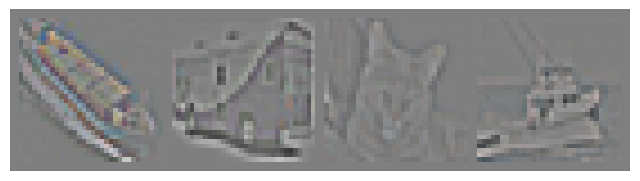

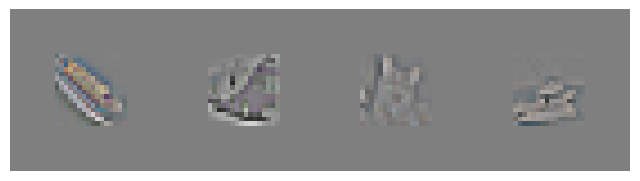

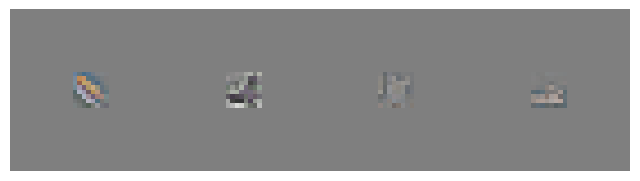

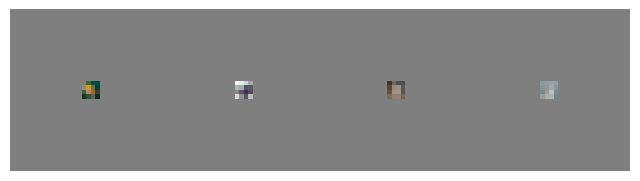

In [56]:
# import torchvision.transforms.functional as F
import torch.nn.functional as F
# define the desired output size for the grid images
# output_size = (4, 3, 32, 32)
output_size = (32, 32)

# resize images to the desired output size
# resized_images = []
# for img in laplacian_pyramid_images:
#     resized_img = F.resize(img, output_size)
#     resized_images.append(resized_img)

# # generate the grid
# image_grid = make_grid(resized_images)

# # Convert the grid to a numpy array and transpose dimensions
# image_grid_np = image_grid.permute(1, 2, 0).numpy()
# # Show the image grid using matplotlib
# plt.figure(figsize=(8,8))
# plt.imshow(image_grid_np)
# plt.axis('off')
# plt.show()
# this does not work: I need the images to be resized to the largest image size
# image_grid = make_grid([laplacian_pyramid_images[0],
#                         laplacian_pyramid_images[1],
#                         laplacian_pyramid_images[2],
#                         laplacian_pyramid_images[3]])
# print("size of image grid:", image_grid.size())
# resize images to the desired output size
padding = [(0,0,0,0), (8,8,8,8), (12,12,12,12), (14,14,14,14)]
# resized_images = []
# for img in laplacian_pyramid_images:
#     # resized_img = F.interpolate(img, size=output_size, mode='bilinear', align_corners=False)
#     resized_img = F.pad(laplacian_pyramid_images[img], padding, mode='constant', value=0)
#     resized_images.append(resized_img)

resized_images = [F.pad(laplacian_pyramid_images[0], padding[0], mode='constant', value=0),
                  F.pad(laplacian_pyramid_images[1], padding[1], mode='constant', value=0),
                  F.pad(laplacian_pyramid_images[2], padding[2], mode='constant', value=0),
                  F.pad(laplacian_pyramid_images[3], padding[3], mode='constant', value=0)]

image_grid0 = make_grid(resized_images[0], nrow=4, padding=2)
image_grid1 = make_grid(resized_images[1], nrow=4, padding=2)
image_grid2 = make_grid(resized_images[2], nrow=4, padding=2)
image_grid3 = make_grid(resized_images[3], nrow=4, padding=2)

# show images
imshow(image_grid0)
imshow(image_grid1)
imshow(image_grid2)
imshow(image_grid3)
